In [1]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
import collections
from scipy.io import loadmat


**Introduce experience replay.**

In [2]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cuda'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device),torch.tensor(isgameon).to(device)
    
    
class PrioritizedExperienceReplay:
    def __init__(self, capacity, alpha=0.6):
        self.alpha = alpha  # Degree of prioritization
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)
        self.priorities = collections.deque(maxlen=capacity)
    
    def __len__(self):
        return len(self.memory)
    
    def push(self, transition, priority=1.0):
        """Saves a transition with an associated priority."""
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
            self.priorities.append(priority)
        else:
            # If memory is full, overwrite the oldest transition with new priority
            self.memory.popleft()
            self.memory.append(transition)
            self.priorities.popleft()
            self.priorities.append(priority)
    
    def sample(self, batch_size, device='cuda', beta=0.4):
        """Samples a batch of transitions weighted by their priority."""
        if len(self.memory) == 0:
            return
        
        priorities = np.array(self.priorities, dtype=np.float32)
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        samples = [self.memory[idx] for idx in indices]
        
        states, actions, next_states, rewards, isgameon = zip(*samples)
        
        # Calculate importance-sampling weights
        weights = (len(self.memory) * probabilities[indices]) ** (-beta)
        weights /= weights.max()  # Normalize for stability
        
        return (torch.tensor(states, dtype=torch.float).to(device), 
                torch.tensor(actions, dtype=torch.long).to(device),
                torch.tensor(next_states, dtype=torch.float).to(device), 
                torch.tensor(rewards, dtype=torch.float).to(device), 
                torch.tensor(isgameon, dtype=torch.bool).to(device),
                indices,
                torch.tensor(weights, dtype=torch.float).to(device))
    
    def update_priorities(self, indices, new_priorities):
        """Updates the priorities of sampled transitions."""
        for idx, priority in zip(indices, new_priorities):
            self.priorities[idx] = priority
    

**Networks definition.**

In [3]:
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4):
        super().__init__()
        
        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        
    def forward(self, x, classification = False, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        
        return out

In [4]:
class conv_nn(nn.Module):
    
    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        
        size_out_conv = self.get_conv_size(rows, cols)
        
        self.linear = nn.Sequential(nn.Linear(size_out_conv, rows*cols*2),
                                    nn.ReLU(),
                                    nn.Linear(rows*cols*2, int(rows*cols/2)),
                                    nn.ReLU(),
                                    nn.Linear(int(rows*cols/2), n_act),
                                   )

    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x),-1)
        out_lin = self.linear(out_conv)
        return out_lin
    
    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1,self.in_channels, x, y))
        return int(np.prod(out_conv.size()))

In [14]:
def Qloss(batch, net, gamma=0.95, device="cuda"):
    states, actions, next_states, rewards, _ = batch
    lbatch = len(states)
    state_action_values = net(states.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    
    next_state_values = net(next_states.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]
    
    next_state_values = next_state_values.detach()
    expected_state_action_values = next_state_values * gamma + rewards
    
    return nn.MSELoss()(state_action_values, expected_state_action_values)

def Qloss_Prio(batch, net, gamma=0.95, device="cuda", return_td_errors=False):
    states, actions, next_states, rewards, _ = batch
    lbatch = len(states)
    state_action_values = net(states.view(lbatch,-1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1)).squeeze(-1)
    
    with torch.no_grad():  # No need to track gradients for the next state
        next_state_values = net(next_states.view(lbatch, -1)).max(1)[0]
    
    expected_state_action_values = (next_state_values * gamma) + rewards
    loss = nn.MSELoss(reduction='none')(state_action_values, expected_state_action_values)
    
    if return_td_errors:
        # Return the loss for each item in the batch (TD errors) and the mean loss
        return loss.mean(), loss
    else:
        return loss.mean()

Qloss(batch, net, gamma=0.95, device="cuda")

tensor([[-9.1214e+00, -1.1017e+01, -9.5985e+00, -1.0223e+01],
        [-1.0284e+01, -1.2313e+01, -1.0761e+01, -1.1581e+01],
        [-1.3612e+01, -1.7025e+01, -1.4010e+01, -1.7096e+01],
        [-6.0466e+00, -6.6479e+00, -5.3924e+00, -6.7827e+00],
        [-7.1240e+00, -8.3092e+00, -6.3736e+00, -8.4803e+00],
        [-7.6943e+00, -9.3256e+00, -7.2960e+00, -9.7782e+00],
        [-5.8391e+00, -6.7961e+00, -5.2737e+00, -6.7939e+00],
        [-1.7310e+01, -2.1951e+01, -1.8671e+01, -2.1348e+01],
        [-3.6978e+00, -4.0047e+00, -2.2267e+00, -4.9090e+00],
        [-2.6143e+00, -2.3948e+00, -1.1974e+00, -3.1433e+00],
        [-7.1613e+00, -8.4726e+00, -7.1424e+00, -8.2200e+00],
        [-2.5294e+00, -2.4104e+00, -8.2452e-01, -3.4117e+00],
        [-7.5927e+00, -8.3755e+00, -6.5745e+00, -8.6883e+00],
        [-2.8782e+00, -2.8042e+00, -1.5372e+00, -3.5155e+00],
        [-1.9897e+00, -1.4609e+00, -8.8590e-02, -2.5343e+00],
        [-7.9759e+00, -8.8771e+00, -7.2232e+00, -8.7924e+00],
        

tensor(10.8644, device='cuda:0', grad_fn=<MseLossBackward0>)

**Import the maze and define the environment.**

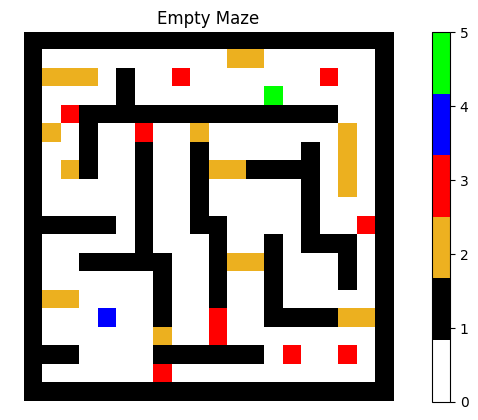

In [6]:
from scipy.io import loadmat

from environment import MazeEnvironment
maze_data = loadmat('Maze_DQN.mat')  # Ensure this matches the structure of the .mat file
maze = maze_data['Maze']

initial_position = [16,4]
goal = [3, 13]

maze_env = MazeEnvironment(maze, initial_position, goal)

maze_env.draw_current()

**Define the agent and the buffer for experience replay.**

In [7]:
buffer_type = "Norm"
model_type = "conv"

In [8]:
buffer_capacity = 10000
buffer_start_size = 1000
if buffer_type == "Priority":
    memory_buffer = PrioritizedExperienceReplay(buffer_capacity)
else:
    memory_buffer = ExperienceReplay(buffer_capacity)


In [9]:
from agent import Agent
agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = False
             )

** Define the network.**

In [10]:
if model_type == "conv":    
    net = conv_nn(len(maze),len(maze),4)
else:
    net = fc_nn(maze.size, maze.size, maze.size, 4)
optimizer = optim.Adam(net.parameters(), lr=1e-4)


In [11]:
device = 'cuda'
batch_size = 24
gamma = 0.95

net.to(device)

conv_nn(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=8192, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=4, bias=True)
  )
)

**Define the epsilon profile and plot the resetting probability.**

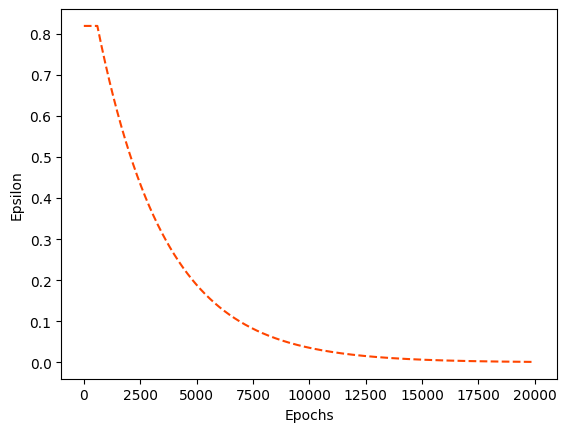

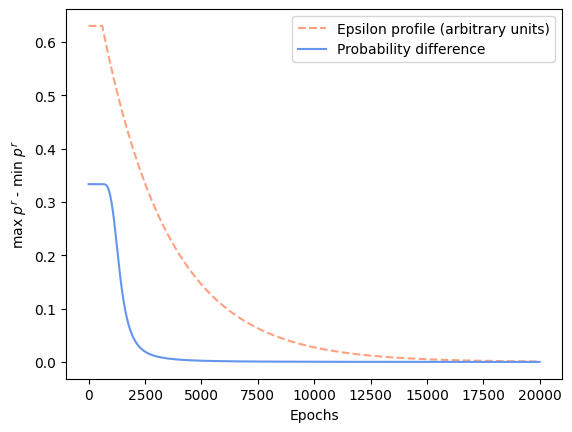

In [12]:
num_epochs = 20000

cutoff = 3000
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]] = epsilon[100*int(num_epochs/cutoff)]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('Results\\epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig('Results\\reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

**Training the network.**

In [13]:
loss_log = []
best_loss = 1e5
previous_running_loss = 1e5  # Initialize with a high value
running_loss = 0
loss_diff = 1e5
average_rewards_log = []
estop = "N/A"

for epoch in range(num_epochs):
    loss = 0
    counter = 0
    eps = epsilon[epoch]
    
    agent.isgameon = True
    _ = agent.env.reset(eps)
    
    while agent.isgameon:
        agent.make_a_move(net, eps,counter)
        counter += 1
        
        if len(agent.buffer) < buffer_start_size:
            continue
        
        if buffer_type == "Priority":
            optimizer.zero_grad()

            # Sample from the prioritized experience replay buffer
            states, actions, next_states, rewards, is_game_on, indices, weights = agent.buffer.sample(batch_size, device=device)
            
            # Calculate loss and TD errors
            loss_t, td_errors = Qloss_Prio((states, actions, next_states, rewards, is_game_on), net, gamma=gamma, device=device, return_td_errors=True)
            
            # Adjust the loss by importance-sampling weights and take the mean
            weighted_loss = (loss_t * weights).mean()
            weighted_loss.backward()
            optimizer.step()
            
            # Update priorities in the buffer with new TD errors
            agent.buffer.update_priorities(indices, td_errors.abs().detach().cpu().numpy())
            
            loss += weighted_loss.item()
        else:
            optimizer.zero_grad()
            batch = agent.buffer.sample(batch_size, device=device)
            loss_t = Qloss(batch, net, gamma=gamma, device=device)
            loss_t.backward()
            optimizer.step()
            
            loss += loss_t.item()
    
    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost'
    
    if epoch % 1000 == 0:
        agent.plot_policy_map(net, f'Results\\DQN_{model_type}_{buffer_type.lower()}_sol_epoch_{epoch}.pdf', [0, 0],f'Gamma ({gamma}), Buffer Capacity ({buffer_capacity}), Batch Size ({batch_size}), Network Type ({model_type})',epoch, title = f"DQN ({buffer_type} Buffer)")
        agent.plot_Q_values(net, f'Results\\DQN_{model_type}_{buffer_type.lower()}_sol_epoch{epoch}_Q_values.pdf', [0, 0],f'Gamma ({gamma}), Buffer Capacity ({buffer_capacity}), Batch Size ({batch_size}), Network Type ({model_type})',epoch, title = f"DQN ({buffer_type} Buffer)")

    
    loss_log.append(loss)
    
    # Evaluate average loss every 50 epochs after 2000 epochs
    
    if epoch > 2000 and epoch % 50 == 0:
        running_loss = np.mean(loss_log[-50:])
        # Update best loss and save the model if there's an improvement
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(net.state_dict(), f"Models\\best_DQN_{model_type}_{buffer_type.lower()}.torch")
            estop = epoch

    if epoch % 20 == 0:
        # Calculate and log the average reward for this run
        counter =0
        agent.isgameon = True
        _ = agent.env.reset_to_starting_tile()

        while agent.isgameon:
            agent.make_a_move(net, eps,counter, testing=True)
            counter += 1

        average_reward = agent.final_total_reward / counter if counter else 0
        average_rewards_log.append(average_reward)
    
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)
    print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
          ' '*int(100*(1 - epoch/num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    print('\t Average Accumulated Reward: ' + f'{average_rewards_log[-1]:.5f}')
    if epoch > 2000:
        print('\t Best running average loss: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop)
        print('\t Running loss: ' + f'{running_loss:.5f}')
    clear_output(wait=True)

KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(), f"Models\\DQN_{model_type}_{buffer_type.lower()}_net.torch")

In [ ]:
num_epochs = 20000
average_rewards_log = np.load('average_rewards_log_DQN_conv_priority.npy')
epochs_with_reward = range(0, num_epochs, 20)[:len(average_rewards_log)]
plt.figure(figsize=(10, 6))
plt.plot(epochs_with_reward, average_rewards_log, linestyle='-', color='blue')
plt.title(f'Average Accumulated Reward vs Epoch (DQN - conv - priority buffer)')
plt.xlabel('Epoch')
plt.ylabel('Average Accumulated Reward')
plt.grid(True)
plt.show()
np.save(f'Results\\average_rewards_log_DQN_{model_type}_{buffer_type.lower()}.npy', average_rewards_log)

**Show the maze solution and the policy learnt.**

In [ ]:
agent.plot_policy_map(net, f'Results\\DQN_{model_type}_{buffer_type}_solution.pdf', [0,0], f'Gamma ({gamma}), Buffer Capacity ({buffer_capacity}), Batch Size ({batch_size}), Network Type ({model_type})',epoch)
agent.plot_Q_values(net, f'Results\\DQN_{model_type}_{buffer_type}_solution_Q_values.pdf', [0,0], f'Gamma ({gamma}), Buffer Capacity ({buffer_capacity}), Batch Size ({batch_size}), Network Type ({model_type})',epoch)
